<a href="https://colab.research.google.com/github/skywalker0803r/c620/blob/main/notebook/c620_Mathematical_Programming_Solver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [71]:
!pip install autorch > log.txt

In [72]:
import joblib
import autorch
from autorch.function import sp2wt
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.optim import Adam

df = pd.read_csv('/content/drive/MyDrive/台塑輕油案子/data/c620/cleaned/c620_train.csv',index_col=0)
c = joblib.load('/content/drive/MyDrive/台塑輕油案子/data/c620/col_names/c620_col_names.pkl')
df.head(3)

,Combined Feed to Tatoray Stripper C620_Flow Rate_Volume Flow Rate_m3/hr,Combined Feed to Tatoray Stripper C620_Flow Rate_Mass Flow Rate_ton/hr,Combined Feed to Tatoray Stripper C620_Detailed Composition_Hydrogen_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Methane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Ethane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Propane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Butane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Pentane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Hexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Benzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Cyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Heptane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Water_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Methylcyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Toluene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Octane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Propylcyclopentane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Ethylcyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Ethylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_p-Xylene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_m-Xylene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_o-Xylene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Nonane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_i-Propylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Propylcyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Propylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-3-ethylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-4-ethylbenzene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,3,5-Trimethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-2-ethylbenzene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2,4-Trimethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_tert-Butylcyclohexane_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2,3-Trimethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_Indane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-4-n-propylbenzene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2-Diethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_5-Ethyl-m-xylene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,4-Diethylbenzene_wt%","Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2,3,5-Tetramethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Pentylbenzene_wt%,...,Tatoray Stripper C620 Split Factors Calculation_Split Factor for Individual Component to Tatoray Stripper C620 Bottoms_n-Hexane_Fraction,Tatoray Stripper C620 Split Factors Calculation_Split Factor for Individual Component to Tatoray Stripper C620 Bottoms_Benzene_Fraction,Tatoray Stripper C620 Split Factors Calculation_Split Factor for Individual Component to Tatoray Stripper C620 Bottoms_Cyclohexane_Fraction,Tatoray Stripper C620 Split Factors Calculation_Split Factor for Individual Component to Tatoray Stripper C620 Bottoms_n-Heptane_Fraction,Tatoray Stripper C620 Split Factors Calculation_Split Factor for Individual Component to Tatoray Stripper C620 Bottoms_Water_Fraction,Tatoray Stripper C620 Split Factors Calculation_Split Factor for Individual Component to Tatoray Stripper C620 Bottoms_Methylcyclohexane_Fraction,Tatoray Stri

# 建立 f(case,input_wt,op) = output_wt

In [73]:
# def columns
input_wt_col = c['x41']
case_col = c['case']
op_col = c['density']+c['yRefluxRate']+c['yHeatDuty']+c['yControl']
sp_col = c['vent_gas_sf'] +c['distillate_sf'] +c['sidedraw_sf'] +c['bottoms_sf']
output_wt_col = c['vent_gas_x'] +c['distillate_x'] +c['sidedraw_x'] +c['bottoms_x']
n_idx = [ [i,i+41,i+41*2,i+41*3] for i in range(41)]

  1%|          | 1/100 [00:00<00:53,  1.84it/s]

epoch:0 train_loss:0.0074 valid_loss:0.0013


 51%|█████     | 51/100 [00:25<00:23,  2.10it/s]

epoch:50 train_loss:0.0009 valid_loss:0.0010


100%|██████████| 100/100 [00:48<00:00,  2.06it/s]


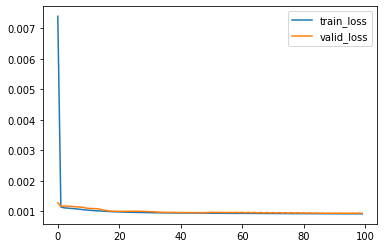

In [74]:
# train
c620_f = autorch.utils.PartBulider(df,case_col+input_wt_col+op_col,sp_col,max_epochs=100,limit_y_range=True,normalize_idx_list=n_idx)
c620_f.net = nn.Sequential(nn.Linear(len(case_col+input_wt_col+op_col),256),nn.Linear(256,256),nn.Linear(256,len(sp_col)),nn.Sigmoid())
c620_f.optimizer = Adam(c620_f.net.parameters(),lr=1e-3)
c620_f.train()

In [75]:
# test
x_test = c620_f.data['X_test']
x41 = df.loc[x_test.index,c['x41']].values
sp = c620_f.predict(x_test).iloc[:,:41*4]
s1,s2,s3,s4 = sp.iloc[:,:41].values,sp.iloc[:,41:41*2].values,sp.iloc[:,41*2:41*3].values,sp.iloc[:,41*3:41*4].values
w1,w2,w3,w4 = sp2wt(x41,s1),sp2wt(x41,s2),sp2wt(x41,s3),sp2wt(x41,s4)
wt_pred = np.hstack((w1,w2,w3,w4))
wt_pred = pd.DataFrame(wt_pred,index=x_test.index,columns=output_wt_col)
wt_real = df.loc[x_test.index,output_wt_col]
res = c620_f.show_metrics(wt_real,wt_pred)
res

,R2,MSE,MAPE
Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Hydrogen_wt%,1,0,NaN
Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Methane_wt%,0.974935,0.000301027,0.778207
Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Ethane_wt%,0.970715,0.0891073,0.582699
Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Propane_wt%,0.954564,0.0139653,0.234681
Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Butane_wt%,0.965336,0.033942,1.59764
...,...,...,...
Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_n-Pentylbenzene_wt%,0.999921,2.1886e-07,0.111571
Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_n-Hexylbenzene_wt%,0.99992,4.04187e-08,0.111571
Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Nitrogen_wt%,1,0,NaN
Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Oxygen_wt%,1,0,NaN


In [76]:
res.loc[['Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Benzene_wt%']]

,R2,MSE,MAPE
Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Benzene_wt%,0.996786,0.213215,0.465967


In [77]:
wt_pred[['Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Benzene_wt%']].head()

,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Benzene_wt%
109-077,69.904985
138-048,69.843223
030-088,70.846046
119-041,80.301278
060-028,90.566217


In [78]:
wt_real[['Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Benzene_wt%']].head()

,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Benzene_wt%
109-077,70.000008
138-048,70.000008
030-088,70.000015
119-041,79.999985
060-028,90.000008


In [79]:
def F(case,input_wt,op):
  sp = c620_f.predict(case.join(input_wt).join(op))
  s1,s2,s3,s4 = sp.iloc[:,:41].values,sp.iloc[:,41:41*2].values,sp.iloc[:,41*2:41*3].values,sp.iloc[:,41*3:41*4].values
  x41 = input_wt.values
  w1,w2,w3,w4 = sp2wt(x41,s1),sp2wt(x41,s2),sp2wt(x41,s3),sp2wt(x41,s4)
  wt_pred = np.hstack((w1,w2,w3,w4))
  wt_pred = pd.DataFrame(wt_pred,index=input_wt.index,columns=output_wt_col)
  return wt_pred

# 建立 g(case,input_wt) = op

In [80]:
path = '/content/drive/MyDrive/台塑輕油案子/data/c620/模擬擴充資料0514.xlsx'
df_extend = pd.read_excel(path)
idx_extend = df_extend.iloc[0,6:].values
case_extend = df_extend.iloc[[5,6,7],6:].T
case_extend.columns = case_col
case_extend.index = idx_extend
case_extend.head(1)

,Tatoray Stripper C620 Operation_Specifications_Spec 1 : Receiver Temp_oC,Tatoray Stripper C620 Operation_Specifications_Spec 2 : Distillate Rate_m3/hr,Tatoray Stripper C620 Operation_Specifications_Spec 3 : Benzene in Sidedraw_wt%
2021-04-15,40.4029,0,74.55


In [81]:
wt_extend = df_extend.iloc[132:132+41,6:].T
wt_extend.columns = input_wt_col
wt_extend.index = idx_extend
wt_extend.head(1)

,Combined Feed to Tatoray Stripper C620_Detailed Composition_Hydrogen_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Methane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Ethane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Propane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Butane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Pentane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Hexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Benzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Cyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Heptane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Water_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Methylcyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Toluene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Octane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Propylcyclopentane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Ethylcyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Ethylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_p-Xylene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_m-Xylene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_o-Xylene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Nonane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_i-Propylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Propylcyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Propylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-3-ethylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-4-ethylbenzene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,3,5-Trimethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-2-ethylbenzene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2,4-Trimethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_tert-Butylcyclohexane_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2,3-Trimethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_Indane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-4-n-propylbenzene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2-Diethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_5-Ethyl-m-xylene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,4-Diethylbenzene_wt%","Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2,3,5-Tetramethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Pentylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Hexylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Nitrogen_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Oxygen_wt%
2021-04-15,0,0.0296863,0.719894,0.653423,0.183413,0.0765324,0.0159367,17.1791,0.00681777,0.0147861,0,0.0109084,37.2087,0.00727228,0.00856008,0.00856008,1.03071,7.28702,15.6964,6.67497,0.0124235,0.00965156,0.00234834,0.0118788,0.801822,0.420214,2.26218,0.236092,5.77757,0,0.922095,0.0415759,0.00115772,0.0254698,0.966693,0,1.11372,0.407516,0.174815,0,0


In [82]:
op_extend = df_extend.iloc[221:221+2,6:].T
op_extend.columns = op_col[-2:]
op_extend.index = idx_extend
op_extend.head(1)

,Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 14 (Control)_oC,Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 34 (Control)_oC
2021-04-15,180.12,195.408


In [83]:
G = joblib.load('/content/drive/MyDrive/台塑輕油案子/data/c620/model/c620_G.pkl')

In [84]:
op_pred = G.predict(case_extend.join(wt_extend))
op_pred = pd.DataFrame(op_pred,columns=op_col,index=idx_extend)
op_pred[op_col[-2:]] = op_extend
op_extend = op_pred
op_extend.head(1)

,Density_Feed Properties,Density_Vent Gas Production Rate and Composition,Density_Distillate Production Rate and Composition,Density_Sidedraw Production Rate and Composition,Density_Bottoms Production Rate and Composition,Tatoray Stripper C620 Operation_Yield Summary_Reflux Rate_m3/hr,Tatoray Stripper C620 Operation_Heat Duty_Condenser Heat Duty_Mkcal/hr,Tatoray Stripper C620 Operation_Heat Duty_Reboiler Heat Duty_Mkcal/hr,Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 14 (Control)_oC,Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 34 (Control)_oC
2021-04-15,0.863383,0.443089,0.799611,0.88019,0.872028,125.481521,12.789003,14.675886,180.12,195.408


In [85]:
df_extend = case_extend.join(wt_extend).join(op_extend).astype('float32')
df_extend.head(1)

,Tatoray Stripper C620 Operation_Specifications_Spec 1 : Receiver Temp_oC,Tatoray Stripper C620 Operation_Specifications_Spec 2 : Distillate Rate_m3/hr,Tatoray Stripper C620 Operation_Specifications_Spec 3 : Benzene in Sidedraw_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Hydrogen_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Methane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Ethane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Propane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Butane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Pentane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Hexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Benzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Cyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Heptane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Water_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Methylcyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Toluene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Octane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Propylcyclopentane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Ethylcyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Ethylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_p-Xylene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_m-Xylene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_o-Xylene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Nonane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_i-Propylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Propylcyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Propylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-3-ethylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-4-ethylbenzene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,3,5-Trimethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-2-ethylbenzene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2,4-Trimethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_tert-Butylcyclohexane_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2,3-Trimethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_Indane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-4-n-propylbenzene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2-Diethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_5-Ethyl-m-xylene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,4-Diethylbenzene_wt%","Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2,3,5-Tetramethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Pentylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Hexylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Nitrogen_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Oxygen_wt%,Density_Feed Properties,Density_Vent Gas Production Rate and Composition,Density_Distillate Production Rate and Composition,Density_Sidedraw Production Rate and Composition,Density_Bottoms Production Rate and Composition,Tatoray Stripper C620 Operation_Yield Summary_Reflux Rate_m3/hr,Tatoray Stripper C620 Operation_Heat Duty_Condenser Heat Duty_Mkcal/hr,Tatoray Stripper C620 Operation_Heat Duty_Reboiler Heat Duty_Mkcal/hr,Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 14 (Control)_oC,Tatoray Stripper C620 Operation_

  2%|▏         | 1/42 [00:00<00:15,  2.59it/s]

epoch:0 train_loss:0.0035 valid_loss:0.0006


100%|██████████| 42/42 [00:16<00:00,  2.58it/s]


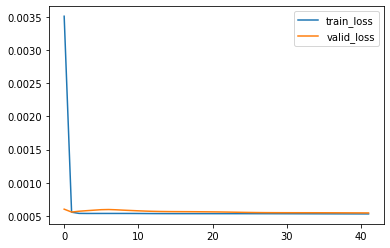

In [86]:
G = autorch.utils.PartBulider(df.append(df_extend),case_col+input_wt_col,op_col,max_epochs=42,limit_y_range=True)
G.net = nn.Sequential(nn.Linear(len(case_col+input_wt_col),256),nn.Linear(256,256),nn.Linear(256,len(op_col)),nn.Sigmoid())
G.optimizer = Adam(G.net.parameters(),lr=1e-3)
G.train()

In [87]:
G.test()

,R2,MSE,MAPE
Density_Feed Properties,0.999394,8.9127e-10,0.00202853
Density_Vent Gas Production Rate and Composition,0.961698,8.57365e-07,0.146712
Density_Distillate Production Rate and Composition,0.928752,7.65987e-06,0.266194
Density_Sidedraw Production Rate and Composition,0.994613,6.05214e-09,0.00809125
Density_Bottoms Production Rate and Composition,0.996253,6.27633e-11,0.000733348
Tatoray Stripper C620 Operation_Yield Summary_Reflux Rate_m3/hr,0.982031,2.34619,0.842008
Tatoray Stripper C620 Operation_Heat Duty_Condenser Heat Duty_Mkcal/hr,0.985716,0.0172733,0.745193
Tatoray Stripper C620 Operation_Heat Duty_Reboiler Heat Duty_Mkcal/hr,0.983097,0.0281499,0.802955
Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 14 (Control)_oC,0.89628,0.137283,0.194722
Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 34 (Control)_oC,0.991443,0.0065913,0.0271941


In [88]:
cond = (df['Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Benzene_wt%'] >= 69) & (df['Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Benzene_wt%'] <= 71)
sample = df[cond].sample(1)
case,input_wt,op = sample[case_col] ,sample[input_wt_col] ,sample[op_col]
F(case,input_wt,op)

,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Hydrogen_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Methane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Ethane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Propane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Butane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Pentane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Hexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Benzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Cyclohexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Heptane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Water_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Methylcyclohexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Toluene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Octane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Propylcyclopentane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Ethylcyclohexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Ethylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_p-Xylene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_m-Xylene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_o-Xylene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Nonane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_i-Propylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Propylcyclohexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Propylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1-Methyl-3-ethylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1-Methyl-4-ethylbenzene_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,3,5-Trimethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1-Methyl-2-ethylbenzene_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,2,4-Trimethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_tert-Butylcyclohexane_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,2,3-Trimethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Indane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1-Methyl-4-n-propylbenzene_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,2-Diethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_5-Ethyl-m-xylene_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,4-Diethylbenzene_wt%","Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,2,3,5-Tetramethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Pentylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Hexylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Nitrogen_wt%,...,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Methane_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Ethane_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Propane_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Com

In [89]:
sample[output_wt_col]

,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Hydrogen_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Methane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Ethane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Propane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Butane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Pentane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Hexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Benzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Cyclohexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Heptane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Water_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Methylcyclohexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Toluene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Octane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Propylcyclopentane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Ethylcyclohexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Ethylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_p-Xylene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_m-Xylene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_o-Xylene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Nonane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_i-Propylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Propylcyclohexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Propylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1-Methyl-3-ethylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1-Methyl-4-ethylbenzene_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,3,5-Trimethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1-Methyl-2-ethylbenzene_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,2,4-Trimethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_tert-Butylcyclohexane_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,2,3-Trimethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Indane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1-Methyl-4-n-propylbenzene_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,2-Diethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_5-Ethyl-m-xylene_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,4-Diethylbenzene_wt%","Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,2,3,5-Tetramethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Pentylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Hexylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Nitrogen_wt%,...,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Methane_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Ethane_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Propane_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Com

In [90]:
sample['Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Benzene_wt%']

078-054    70.000008
Name: Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Benzene_wt%, dtype: float64

# 數學規劃求解器

透過調整op 來讓 'Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Benzene_wt%'  == 70

In [91]:
!pip install optuna > log.txt

In [92]:
sample[input_wt_col]

,Combined Feed to Tatoray Stripper C620_Detailed Composition_Hydrogen_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Methane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Ethane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Propane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Butane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Pentane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Hexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Benzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Cyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Heptane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Water_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Methylcyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Toluene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Octane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Propylcyclopentane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Ethylcyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Ethylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_p-Xylene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_m-Xylene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_o-Xylene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Nonane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_i-Propylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Propylcyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Propylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-3-ethylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-4-ethylbenzene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,3,5-Trimethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-2-ethylbenzene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2,4-Trimethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_tert-Butylcyclohexane_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2,3-Trimethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_Indane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-4-n-propylbenzene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2-Diethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_5-Ethyl-m-xylene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,4-Diethylbenzene_wt%","Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2,3,5-Tetramethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Pentylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Hexylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Nitrogen_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Oxygen_wt%
078-054,0.0,0.018298,0.443738,0.412712,0.12853,0.071674,0.014892,16.525991,0.007658,0.015105,0.0,0.012254,46.084351,0.008169,0.009616,0.009616,0.733654,5.038924,10.674891,4.729251,0.013955,0.011894,0.002638,0.014639,0.988117,0.517846,2.78777,0.290945,7.119931,0.0,1.136334,0.051236,0.000915,0.020128,0.763961,0.0,0.880156,0.322053,0.138153,0.0,0.0


In [93]:
sample[['Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Benzene_wt%']]

,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Benzene_wt%
078-054,70.000008


In [96]:
op_max = df.append(df_extend)[op_col].max().to_dict()
op_min = df.append(df_extend)[op_col].min().to_dict()

In [97]:
op_max

{'Density_Bottoms Production Rate and Composition': 0.8722013448663097,
 'Density_Distillate Production Rate and Composition': 0.8276968447728095,
 'Density_Feed Properties': 0.8646730162921348,
 'Density_Sidedraw Production Rate and Composition': 0.8816900667286587,
 'Density_Vent Gas Production Rate and Composition': 0.4596509754645822,
 'Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 14 (Control)_oC': 181.28814697265625,
 'Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 34 (Control)_oC': 195.40753173828125,
 'Tatoray Stripper C620 Operation_Heat Duty_Condenser Heat Duty_Mkcal/hr': 15.352493044000001,
 'Tatoray Stripper C620 Operation_Heat Duty_Reboiler Heat Duty_Mkcal/hr': 17.330535890000007,
 'Tatoray Stripper C620 Operation_Yield Summary_Reflux Rate_m3/hr': 151.33982849999998}

In [98]:
op_min

{'Density_Bottoms Production Rate and Composition': 0.8718550196589577,
 'Density_Distillate Production Rate and Composition': 0.7715259991981224,
 'Density_Feed Properties': 0.8620919983765354,
 'Density_Sidedraw Production Rate and Composition': 0.8786906178745657,
 'Density_Vent Gas Production Rate and Composition': 0.42652801816569175,
 'Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 14 (Control)_oC': 174.52383419999998,
 'Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 34 (Control)_oC': 191.5879211,
 'Tatoray Stripper C620 Operation_Heat Duty_Condenser Heat Duty_Mkcal/hr': 10.416381362000001,
 'Tatoray Stripper C620 Operation_Heat Duty_Reboiler Heat Duty_Mkcal/hr': 12.03581238,
 'Tatoray Stripper C620 Operation_Yield Summary_Reflux Rate_m3/hr': 97.02017975}

In [99]:
joblib.dump(op_max,'/content/drive/MyDrive/台塑輕油案子/data/c620/map_dict/c620_op_max.pkl')
joblib.dump(op_min,'/content/drive/MyDrive/台塑輕油案子/data/c620/map_dict/c620_op_min.pkl')

['/content/drive/MyDrive/台塑輕油案子/data/c620/map_dict/c620_op_min.pkl']

In [100]:
import optuna

# 目標函數
def objective(trial):
  
  # 可控變數
  op_dict = {}
  for name in op_col:
    op_dict[name] = trial.suggest_uniform(name,op_min[name],op_max[name])
  op = pd.DataFrame(op_dict,index=sample.index)
  
  # 計算loss
  輸入端bz = sample[case_col]['Tatoray Stripper C620 Operation_Specifications_Spec 3 : Benzene in Sidedraw_wt%'][0]
  輸出端bz = F(sample[case_col],sample[input_wt_col],op)['Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Benzene_wt%'].values[0]
  loss = (輸入端bz - 輸出端bz)**2
  
  return loss

In [101]:
# 做搜索
study = optuna.create_study()
study.optimize(objective, n_trials=300)
op_opt = pd.DataFrame(study.best_params,index=sample.index)

[I 2021-05-16 08:03:42,585] A new study created in memory with name: no-name-b0518111-5800-480f-ab24-c208b33f2473
[I 2021-05-16 08:03:42,662] Trial 0 finished with value: 16.638574132171176 and parameters: {'Density_Feed Properties': 0.8629508189641996, 'Density_Vent Gas Production Rate and Composition': 0.43256453832751574, 'Density_Distillate Production Rate and Composition': 0.8046637312890994, 'Density_Sidedraw Production Rate and Composition': 0.8789469106881884, 'Density_Bottoms Production Rate and Composition': 0.8719987800113157, 'Tatoray Stripper C620 Operation_Yield Summary_Reflux Rate_m3/hr': 122.31966545642706, 'Tatoray Stripper C620 Operation_Heat Duty_Condenser Heat Duty_Mkcal/hr': 14.431869303122788, 'Tatoray Stripper C620 Operation_Heat Duty_Reboiler Heat Duty_Mkcal/hr': 14.354609907839441, 'Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 14 (Control)_oC': 181.0609431185794, 'Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 34 (Control)_oC': 1

In [102]:
#搜索結果
op_opt

,Density_Feed Properties,Density_Vent Gas Production Rate and Composition,Density_Distillate Production Rate and Composition,Density_Sidedraw Production Rate and Composition,Density_Bottoms Production Rate and Composition,Tatoray Stripper C620 Operation_Yield Summary_Reflux Rate_m3/hr,Tatoray Stripper C620 Operation_Heat Duty_Condenser Heat Duty_Mkcal/hr,Tatoray Stripper C620 Operation_Heat Duty_Reboiler Heat Duty_Mkcal/hr,Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 14 (Control)_oC,Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 34 (Control)_oC
078-054,0.864094,0.442758,0.794428,0.881137,0.872175,135.993449,12.785484,14.00119,175.842156,192.690199


In [103]:
# 看有沒有符合業主需要的70
F(case,input_wt,op_opt)[['Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Benzene_wt%']]

,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Benzene_wt%
078-054,69.997825


In [104]:
op_pred = G.predict(sample[case_col+input_wt_col])

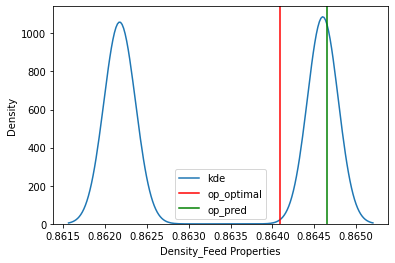

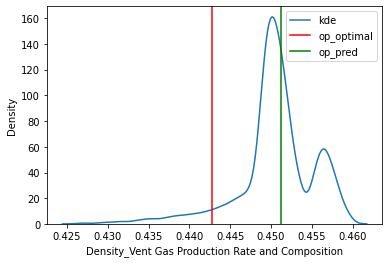

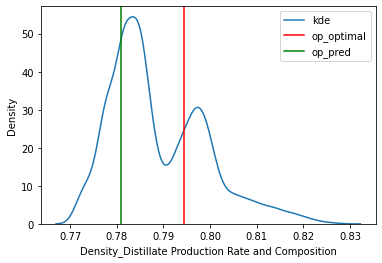

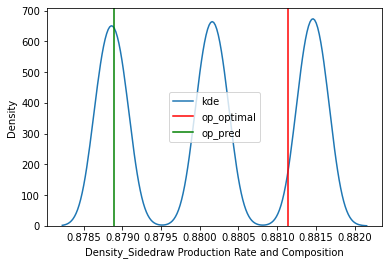

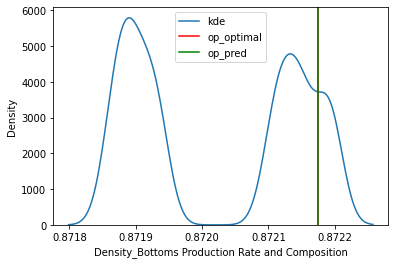

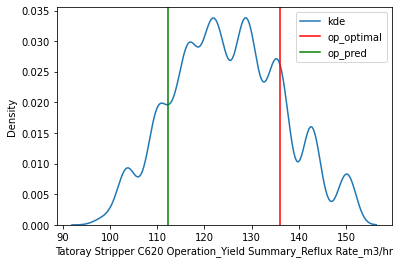

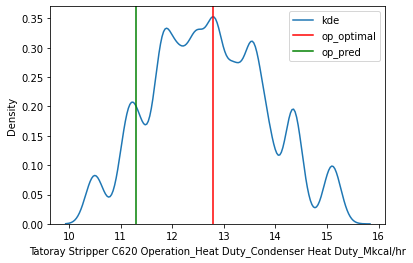

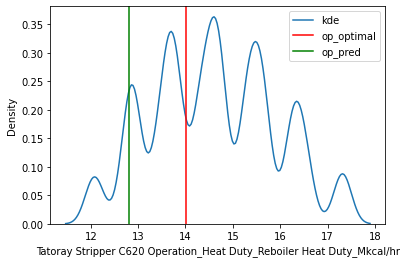

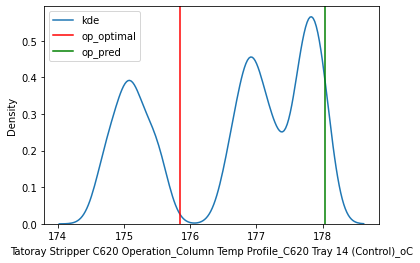

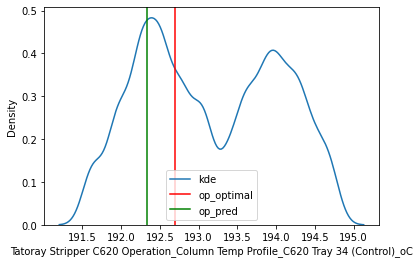

In [105]:
import seaborn as sb
import matplotlib.pyplot as plt

for i in op_col:
 sb.kdeplot(df[op_col][i],label='kde')
 plt.axvline(op_opt[i][0],label='op_optimal',c='red')
 plt.axvline(op_pred[i][0],label='op_pred',c='green')
 plt.legend()
 plt.show()

In [106]:
import joblib
G.shrink()
c620_f.shrink()
joblib.dump(G,'/content/drive/MyDrive/台塑輕油案子/data/c620/model/c620_G.pkl')
joblib.dump(c620_f,'/content/drive/MyDrive/台塑輕油案子/data/c620/model/c620_F.pkl')

['/content/drive/MyDrive/台塑輕油案子/data/c620/model/c620_F.pkl']